<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/%D0%93%D0%B5%D0%B9%D0%BC%D1%81_%D0%A5%D0%B0%D1%83%D1%8D%D0%BB%D0%BB_%D0%B4%D0%BB%D1%8F_MTLD_%D0%B8_HD_D_%D0%BF%D0%BE_%D0%BB%D0%B5%D0%BC%D0%BC%D0%B0%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 5.1 MB/s eta 0:00:00


In [2]:
!pip install lexicalrichness

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lexicalrichness: filename=lexicalrichness-0.5.1-py3-none-any.whl size=15414 sha256=c0830aaa3475c5eb3cc9f1acb580af6c0f0b53b1bc70b63506205c67d819ef8a
  Stored in directory: /root/.cache/pip/wheels/cd/ba/80/d4dabc1bf242a672ffc00226a2303a7471bb841c0872b2c212
Successfully built lexicalrichness


In [3]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=bf88649c543e70b9e3446d65056e252d6b3e1012cf42b98bb50e9cb7b5eda2bb
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [4]:
import os
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from collections import defaultdict
from lexicalrichness import LexicalRichness
import pymorphy2
import pandas as pd
import pingouin as pg

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
import os
import re
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import pingouin as pg
import numpy as np
from lexicalrichness import LexicalRichness
import pymorphy2

# Устанавливаем стоп-слова для русского языка
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

class MetricsCalculator:
    morph_analyzer = pymorphy2.MorphAnalyzer()

    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.hd_data = defaultdict(list)
        self.mtld_data = defaultdict(list)
        self.file_names = []

    def preprocess_text(self, text):
        if isinstance(text, list):
            text = [str(item).lower() for item in text]
        else:
            text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\n', '', text)
        return text

    def lemmatize_text(self, text):
        lemmas = [self.morph.parse(token)[0].normal_form for token in word_tokenize(text)]
        return lemmas

    def calculate_ttr(self, lemmas):
        total_lemmas = len(lemmas)
        unique_lemmas = len(set(lemmas))
        ttr = unique_lemmas / total_lemmas
        return ttr

    def process_files(self, directory):
        cefr_levels = ['A1', 'A2', 'B1', 'B2']

        for cefr_level in cefr_levels:
            cefr_dir = os.path.join(directory, cefr_level)
            if os.path.isdir(cefr_dir):
                for filename in os.listdir(cefr_dir):
                    if filename.endswith(".txt"):
                        filepath = os.path.join(cefr_dir, filename)
                        with open(filepath, "r", encoding="utf-8") as file:
                            text = file.read()
                            preprocessed_text = self.preprocess_text(text)
                            tokens = word_tokenize(preprocessed_text)
                            # Фильтрация на количество лемм (больше или равно 50)
                            if len(tokens) >= 50:
                                # Используем лемматизацию
                                lemmas = [self.morph_analyzer.parse(token.lower())[0].normal_form for token in tokens]
                                # Объединяем леммы в строку
                                lemmas_str = ' '.join(lemmas)
                                lex = LexicalRichness(lemmas_str)
                                hd = lex.hdd(draws=20)
                                mtld = lex.mtld(threshold=0.72)
                                self.hd_data[cefr_level].append(hd)
                                self.mtld_data[cefr_level].append(mtld)
                                self.file_names.append(filename)

    def calculate_avg_metrics(self):
        avg_hd = {}
        avg_mtld = {}

        for cefr_level, hd_values in self.hd_data.items():
            avg_hd[cefr_level] = sum(hd_values) / len(hd_values)

        for cefr_level, mtld_values in self.mtld_data.items():
            avg_mtld[cefr_level] = sum(mtld_values) / len(mtld_values)

        return avg_hd, avg_mtld

    def save_to_excel(self, output_path):
        data = {
            'File Name': self.file_names,
            'CEFR Level': [],
            'HD-D': [],
            'MTLD': []
        }

        avg_hd, avg_mtld = self.calculate_avg_metrics()

        for cefr_level in avg_hd.keys():
            data['CEFR Level'].extend([cefr_level] * len(self.hd_data[cefr_level]))
            data['HD-D'].extend(self.hd_data[cefr_level])
            data['MTLD'].extend(self.mtld_data[cefr_level])

        df = pd.DataFrame(data)
        df.to_excel(output_path, index=False)

    def calculate_and_print_stats(self, metric_data, metric_name):
        print(f"\n--- {metric_name} ---")
        data = []
        for cefr_level, values in metric_data.items():
            data.extend(list(zip([cefr_level] * len(values), values)))
        df = pd.DataFrame(data, columns=['CEFR Level', metric_name])

        # One-way ANOVA
        anova_result = pg.anova(data=df, dv=metric_name, between='CEFR Level')
        print(f"ANOVA F-statistic ({metric_name}): {anova_result['F'][0]}")
        print(f"ANOVA p-value ({metric_name}): {anova_result['p-unc'][0]}")

        # Games-Howell post hoc test
        games_howell_result = pg.pairwise_gameshowell(data=df, dv=metric_name, between='CEFR Level')
        print(f"\nGames-Howell Test Results for {metric_name}:")
        print(games_howell_result)

if __name__ == "__main__":
    directory_path = "/content/Students_texts"
    output_excel_path = "/content/lexical_metrics_lemmas.xlsx"

    metrics_calculator = MetricsCalculator(threshold=0.72)
    metrics_calculator.process_files(directory_path)

    metrics_calculator.calculate_and_print_stats(metrics_calculator.hd_data, 'HD-D')
    metrics_calculator.calculate_and_print_stats(metrics_calculator.mtld_data, 'MTLD')

    avg_hd, avg_mtld = metrics_calculator.calculate_avg_metrics()

    for cefr_level, avg in avg_hd.items():
        print(f"CEFR Level: {cefr_level}, Avg HD-D: {avg:.4f}")

    for cefr_level, avg in avg_mtld.items():
        print(f"CEFR Level: {cefr_level}, Avg MTLD: {avg:.4f}")

    metrics_calculator.save_to_excel(output_excel_path)

    # Считаем статистики для MTLD
    all_mtld_values = [value for values in metrics_calculator.mtld_data.values() for value in values]
    mean_mtld_all = np.mean(all_mtld_values)
    sd_mtld_all = np.std(all_mtld_values)
    std_error_mtld_all = np.std(all_mtld_values) / np.sqrt(len(all_mtld_values))
    ci_mtld_all = pg.compute_bootci(all_mtld_values, func=np.mean)

    # Считаем статистики для HD-D
    all_hd_values = [value for values in metrics_calculator.hd_data.values() for value in values]
    mean_hd_all = np.mean(all_hd_values)
    sd_hd_all = np.std(all_hd_values)
    std_error_hd_all = np.std(all_hd_values) / np.sqrt(len(all_hd_values))
    ci_hd_all = pg.compute_bootci(all_hd_values, func=np.mean)

    # Выводим статистики для MTLD
    print("\nStatistics for MTLD:")
    print(f"Mean: {mean_mtld_all}")
    print(f"SD: {sd_mtld_all}")
    print(f"Std. Error: {std_error_mtld_all}")
    print(f"95% CI (confidence interval) (mean): {ci_mtld_all}")

    # Выводим статистики для HD-D
    print("\nStatistics for HD-D:")
    print(f"Mean: {mean_hd_all}")
    print(f"SD: {sd_hd_all}")
    print(f"Std. Error: {std_error_hd_all}")
    print(f"95% CI (confidence interval) (mean): {ci_hd_all}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



--- HD-D ---
ANOVA F-statistic (HD-D): 109.48880520318244
ANOVA p-value (HD-D): 1.9239404181957904e-61

Games-Howell Test Results for HD-D:
    A   B   mean(A)   mean(B)      diff        se          T          df  \
0  A1  A2  0.840188  0.872028 -0.031840  0.007261  -4.384805   43.467928   
1  A1  B1  0.840188  0.896017 -0.055830  0.007187  -7.767810   41.727984   
2  A1  B2  0.840188  0.912891 -0.072704  0.007278  -9.989277   43.832460   
3  A2  B1  0.872028  0.896017 -0.023990  0.002124 -11.295473  782.471790   
4  A2  B2  0.872028  0.912891 -0.040864  0.002413 -16.931528  366.707208   
5  B1  B2  0.896017  0.912891 -0.016874  0.002180  -7.739463  283.949936   

           pval    hedges  
0  4.091898e-04 -0.918641  
1  7.337776e-09 -1.882172  
2  4.308554e-12 -2.614311  
3  0.000000e+00 -0.782000  
4  9.270362e-14 -1.328530  
5  9.349188e-13 -0.639385  

--- MTLD ---
ANOVA F-statistic (MTLD): 87.07518249648308
ANOVA p-value (MTLD): 3.7183532817126207e-50

Games-Howell Test Results 

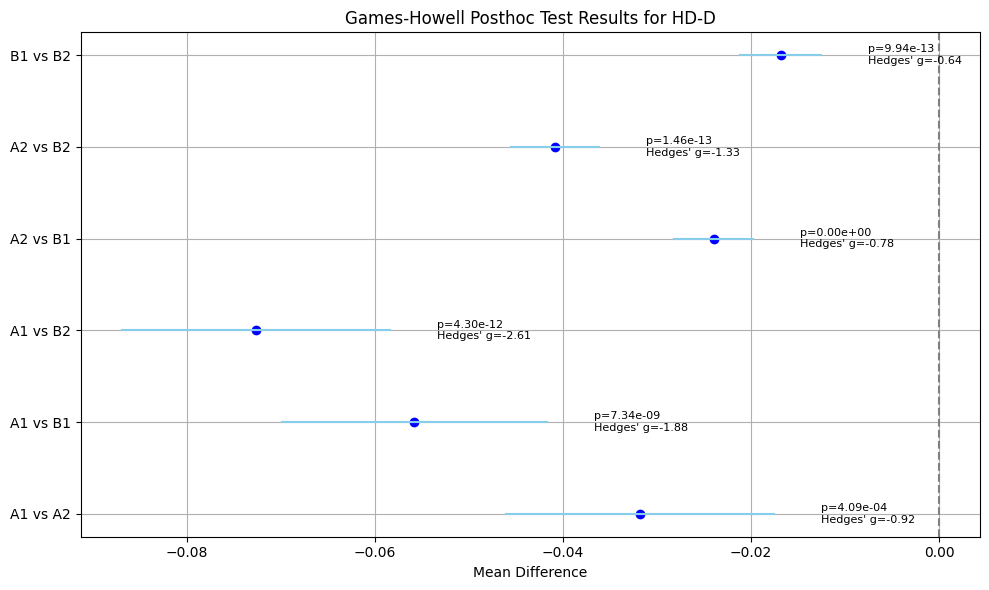

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Определение z_score
z_score = 1.96

# Ваши результаты для HD-D
games_howell_result_hd = pd.DataFrame({
    'A': ['A1', 'A1', 'A1', 'A2', 'A2', 'B1'],
    'B': ['A2', 'B1', 'B2', 'B1', 'B2', 'B2'],
    'mean(A)': [0.840188, 0.840188, 0.840188, 0.872028, 0.872028, 0.896017],
    'mean(B)': [0.872028, 0.896017, 0.912891, 0.896017, 0.912891, 0.912891],
    'diff': [-0.031840, -0.055830, -0.072704, -0.023990, -0.040864, -0.016874],
    'se': [0.007261, 0.007187, 0.007278, 0.002124, 0.002413, 0.002180],
    'T': [-4.384805, -7.767810, -9.989277, -11.295473, -16.931528, -7.739463],
    'df': [43.467928, 41.727984, 43.832460, 782.471790, 366.707208, 283.949936],
    'pval': [4.091898e-04, 7.337798e-09, 4.304890e-12, 0.000000e+00, 1.464384e-13, 9.935386e-13],
    'hedges': [-0.918641, -1.882172, -2.614311, -0.782000, -1.328530, -0.639385]
})

# Функция для построения диаграмм
def plot_games_howell(games_howell_result, metric_name):
    # Confidence intervals
    conf_intervals = [
        (md - z_score * s, md + z_score * s) for md, s in zip(games_howell_result['diff'], games_howell_result['se'])
    ]

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, (group, ci, p, h) in enumerate(
        zip(games_howell_result['A'] + ' vs ' + games_howell_result['B'], conf_intervals, games_howell_result['pval'], games_howell_result['hedges'])
    ):
        plt.plot(ci, [i, i], color="skyblue")
        plt.scatter(games_howell_result['diff'].iloc[i], i, color="blue")
        plt.text(ci[1] + 0.005, i, f"p={p:.2e}\nHedges' g={h:.2f}", va='center', ha='left', fontsize=8)  # Изменено расположение текста

    # Formatting
    plt.yticks(range(len(games_howell_result)), games_howell_result['A'] + ' vs ' + games_howell_result['B'])
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel("Mean Difference")
    plt.title(f"Games-Howell Posthoc Test Results for {metric_name}")
    plt.grid(True)
    plt.tight_layout()  # Улучшение композиции графика
    plt.show()

# Построение диаграммы для HD-D
plot_games_howell(games_howell_result_hd, 'HD-D')

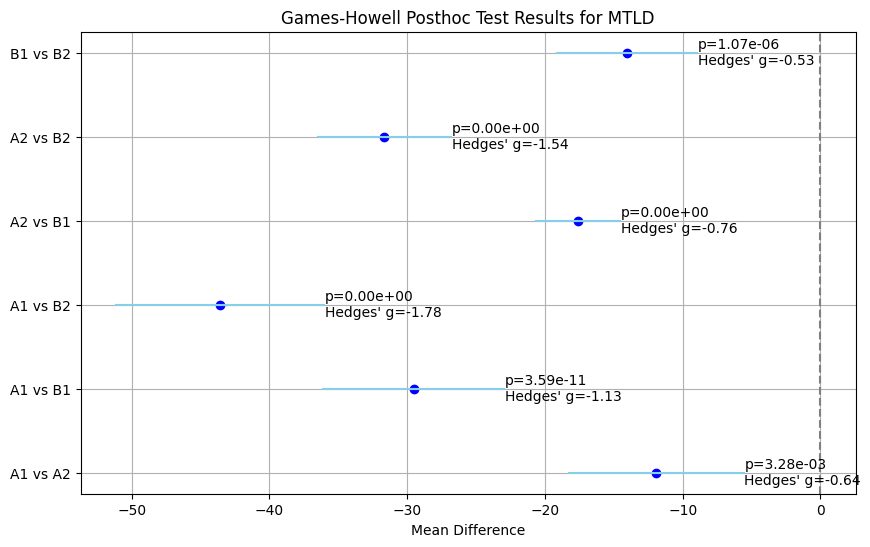

In [8]:
# Ваши результаты для MTLD
games_howell_result_mtld = pd.DataFrame({
    'A': ['A1', 'A1', 'A1', 'A2', 'A2', 'B1'],
    'B': ['A2', 'B1', 'B2', 'B1', 'B2', 'B2'],
    'mean(A)': [41.986184, 41.986184, 41.986184, 53.918124, 53.918124, 71.522829],
    'mean(B)': [53.918124, 71.522829, 85.571157, 71.522829, 85.571157, 85.571157],
    'diff': [-11.931941, -29.536645, -43.584973, -17.604705, -31.653033, -14.048328],
    'se': [3.241465, 3.349166, 3.852501, 1.558868, 2.460675, 2.600911],
    'T': [-3.681034, -8.819105, -11.313423, -11.293260, -12.863557, -5.401310],
    'df': [46.228696, 52.606636, 84.708283, 809.998235, 169.713442, 208.372707],
    'pval': [3.284256e-03, 3.586365e-11, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.072147e-06],
    'hedges': [-0.638022, -1.125302, -1.778663, -0.756737, -1.541709, -0.529828]
})

# Функция для построения диаграмм
def plot_games_howell(games_howell_result, metric_name):
    # Confidence intervals
    conf_intervals = [
        (md - z_score * s, md + z_score * s) for md, s in zip(games_howell_result['diff'], games_howell_result['se'])
    ]

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, (group, ci, p, h) in enumerate(
        zip(games_howell_result['A'] + ' vs ' + games_howell_result['B'], conf_intervals, games_howell_result['pval'], games_howell_result['hedges'])
    ):
        plt.plot(ci, [i, i], color="skyblue")
        plt.scatter(games_howell_result['diff'].iloc[i], i, color="blue")
        plt.text(ci[1] + 0.05, i, f"p={p:.2e}\nHedges' g={h:.2f}", va='center')

    # Formatting
    plt.yticks(range(len(games_howell_result)), games_howell_result['A'] + ' vs ' + games_howell_result['B'])
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel("Mean Difference")
    plt.title(f"Games-Howell Posthoc Test Results for {metric_name}")
    plt.grid(True)
    plt.show()

# Построение диаграммы для MTLD
plot_games_howell(games_howell_result_mtld, 'MTLD')